# NSF Computer and Information Science and Engineering (CISE) 

- `05050000`: Division of Computer and Network Systems (CNS)
- `05010000`: Division of Computing and Communication Foundations (CCF)
- `05020000`: Division of Information and Intelligent Systems (IIS)
- `05090000`: Office of Advanced Cyberinfrastructure (OAC)

In [1]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [2]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "05050000": "Division of Computer and Network Systems (CNS)",
    "05010000": "Division of Computing and Communication Foundations (CCF)",
    "05020000": "Division of Information and Intelligent Systems (IIS)",
    "05090000": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [3]:
def histogram_num_pis(data, years, orgcodes):
    plt.title("[NSF {}-{}] histogram - number of PIs".format(years[0], years[-1]))
    plt.ylabel("Number of grants")
    plt.xlabel("Number of PIs")
    pis = [d["num_pis"] for d in data.values() if d["org"] in orgcodes]
    counter_pis = Counter(pis)
    print(counter_pis)
    x = range(1, 10)
    y = [counter_pis[i] if i in counter_pis else 0 for i in x]
    plt.bar(x, y)

In [4]:
def plot_coauthor_heatmap_paper(pid, pi_only):
    table, ts, te, G = core.coworknet.get_grant_coworknet_pis(pid)
    authors_sorted = sorted(G.nodes(data=True), key=lambda x: x[1]["paperCount"], reverse=True)
    authors_sorted = sorted(authors_sorted, key=lambda x: x[1]["pi"], reverse=True)
    authors_dict = {k:d for k, d in authors_sorted}
    authors = authors_dict.keys()
    
    if pi_only:
        authors = [a for a in authors if "pi" in G.nodes[a] and G.nodes[a]["pi"]]
    
#     print(authors)
    
    if len(table) == 0:
        no_publications.append(pid)
        return
    
    convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")
    # calculate coauthorship by papar
    times = sorted([convert_t(v["date"]) for v in table.values()])
    dates = {convert_t(v["date"]):v["authors"] for v in table.values()}
    dates_ingrant = [convert_t(v["date"]) for v in table.values() if v["type"]]
    coauthored = np.array([[2 if ts <= t and t <= te and a in dates[t] else (1 if a in dates[t] else 0) for t in times] for a in authors])
    coauthored_ingrant = np.array([[1 if t in dates_ingrant and a in dates[t] else 0 for t in times] for a in authors])
    
    fig, ax = plt.subplots(figsize=(len(times)/5,len(authors)/2))
    im = ax.imshow(coauthored, cmap="GnBu", vmin=0)

    ax.set_xticks(np.arange(len(times)))
    ax.set_yticks(np.arange(len(authors)))
    ax.set_xticklabels([datetime.strftime(t, "%Y-%m-%d") for t in times])
    ax.set_yticklabels(["{} {} ({})".format("*" if authors_dict[a]["pi"] else "", a, authors_dict[a]["paperCount"]) for a in authors])
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    for i in range(len(authors)):
        for j in range(len(times)):
            label = "*" if coauthored_ingrant[i, j] > 0 else ""
            text = ax.text(j, i, label, ha="center", va="center", color="black")

    ax.set_title("{} ({}~{})".format(pid, datetime.strftime(ts, "%Y-%m-%d"), datetime.strftime(te, "%Y-%m-%d")))
    plt.show()

In [5]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 405
Division of Computing and Communication Foundations (CCF) 332
Division of Information and Intelligent Systems (IIS) 362
Office of Advanced Cyberinfrastructure (OAC) 53


Counter({1: 633, 2: 243, 3: 123, 5: 83, 4: 61, 6: 4, 0: 2, 7: 2, 8: 1})


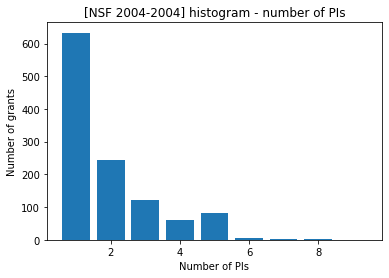

In [6]:
histogram_num_pis(data, years, div_type.keys())

In [7]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427', '0429154', '0429211'

In [8]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

243 grants with 2 PIs


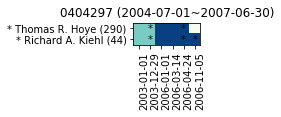

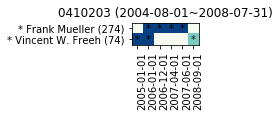

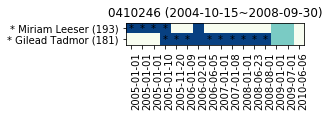

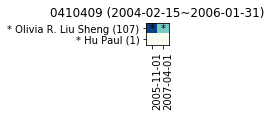

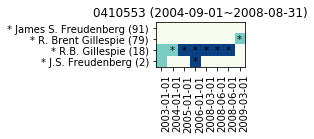

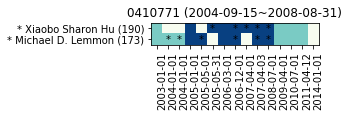

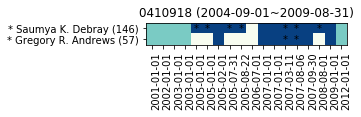

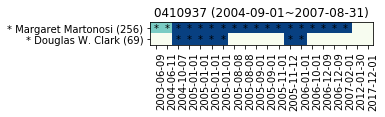

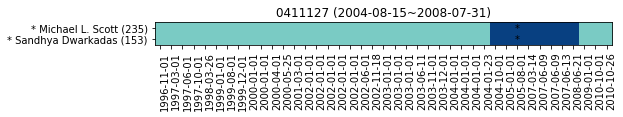

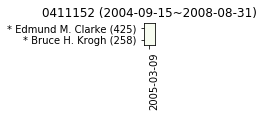

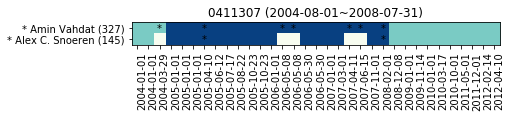

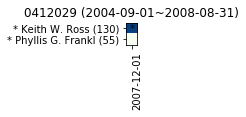

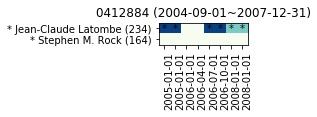

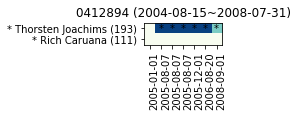

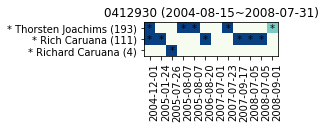

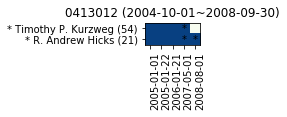

14 grants have no publication ['0401049', '0403020', '0403130', '0403590', '0404001', '0404193', '0404440', '0406305', '0406345', '0406384', '0410524', '0410790', '0412858', '0412965']


In [13]:
no_publications = []
for pid in grant_list[:30]:
    plot_coauthor_heatmap_paper(pid, pi_only=True)
print("{} grants have no publication".format(len(no_publications)), no_publications)

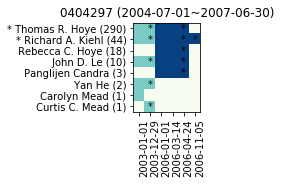

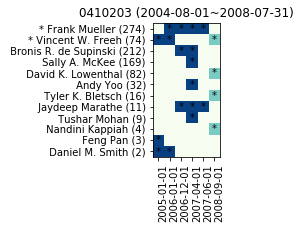

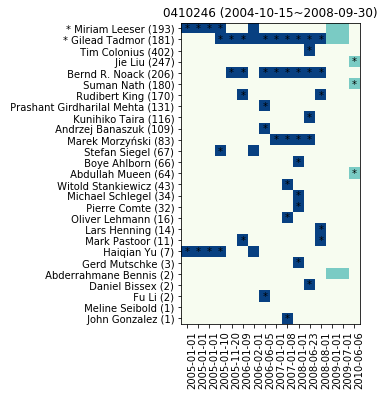

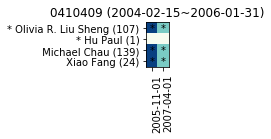

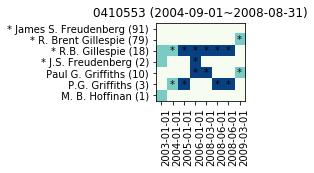

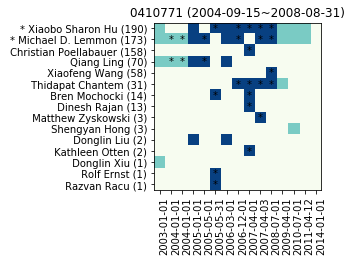

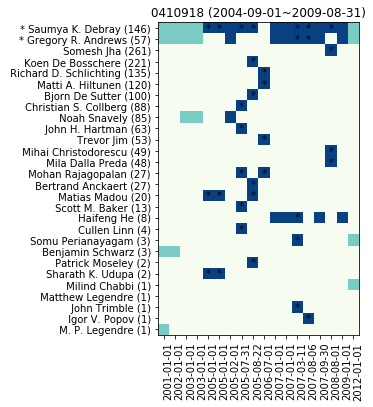

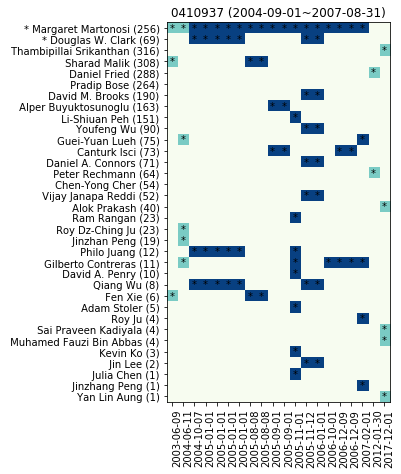

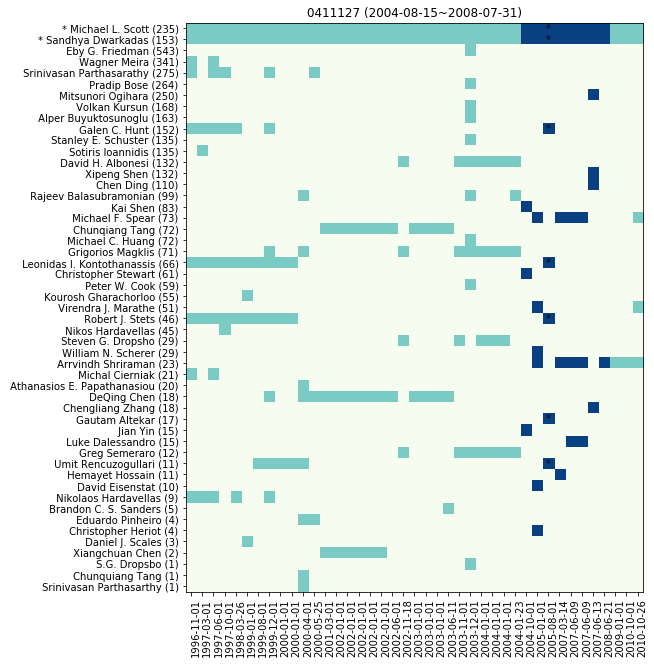

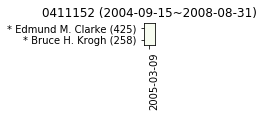

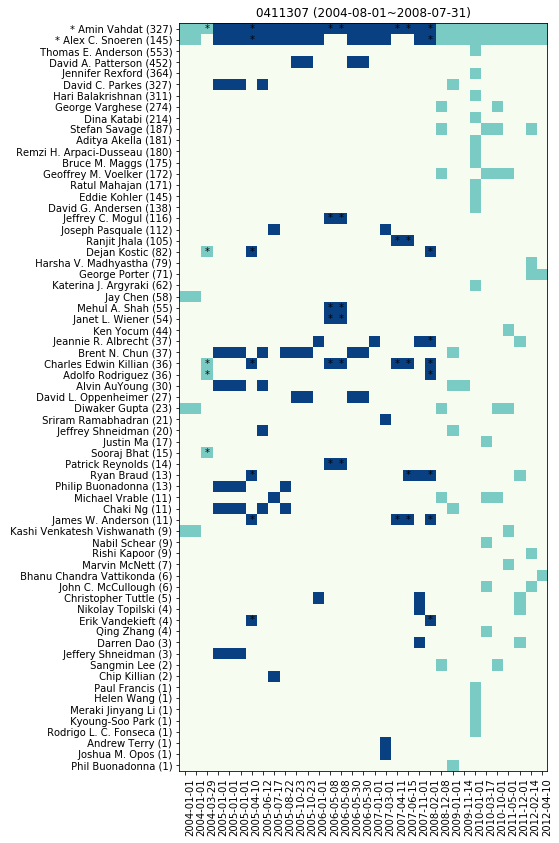

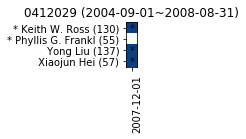

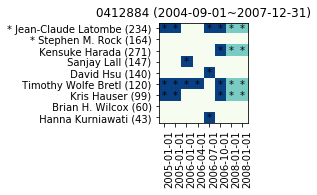

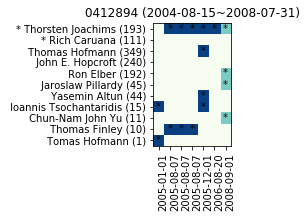

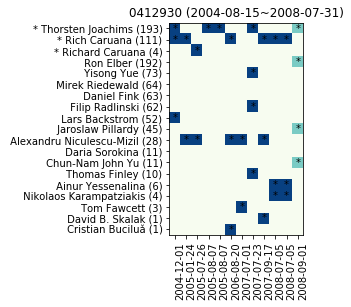

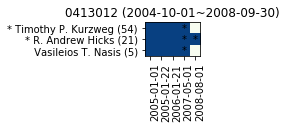

In [14]:
no_publications = []
for pid in grant_list[:30]:
    plot_coauthor_heatmap_paper(pid, pi_only=False)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


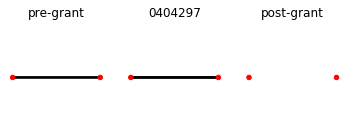

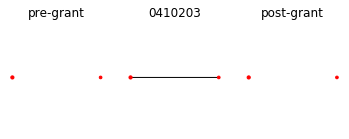

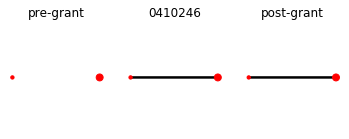

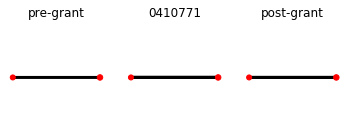

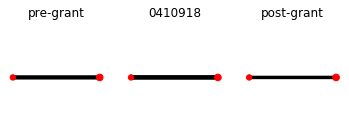

In [11]:
for grant_id in grant_list[:20]:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    authors = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(authors)
        
    if len(G.edges) == 0:
        continue
#     print(G.edges.data())
    fig = plt.figure(figsize=(6,2))
    pos = nx.circular_layout(G)
    convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")
    
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        e_colors = []
        n_colors = []
        weight = []
        for v,data in G.nodes.data():
            n_colors.append("red") 
        for u,v,data in G.edges.data():
            if nxtype == "pre-grant":
                e_colors.append("black" if convert_t(data["date"]) < ts else "white")
                weight.append(np.sqrt(len(G[u][v])) if convert_t(data["date"]) < ts else 0)
            if nxtype == "grant":
                e_colors.append("black" if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else "white")
                weight.append(np.sqrt(len(G[u][v])) if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0)
            if nxtype == "post-grant":
                e_colors.append("black" if te < convert_t(data["date"]) else "white")
                weight.append(np.sqrt(len(G[u][v])) if te < convert_t(data["date"]) else 0)
        fig.add_subplot(1,3,1+idx).set_title(grant_id if nxtype == "grant" else nxtype)
        degree = [G_all.degree(i) for i in G.nodes()]
        nx.draw(G, pos, node_size=degree, node_color=n_colors, edge_alpha=e_colors, width=weight)

In [41]:
no_publications = []
collab_type = {}
dict_publications = {}
dict_citations = {}
dict_periods = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G_all.edges) == 0:
        no_publications.append(grant_id)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    acting_authors = []
    G = G_all.subgraph(pis)
    if len(G.edges) == 0:
        collab_type[grant_id] = "000"
        
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G_all.edges.data()]
    periods = {"pre-grant":max(0, (ts-min(dates)).days), "grant":(te-ts).days, "post-grant":max(0, (max(dates)-te).days)}
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        for u,v,data in G_all.edges.data():
            acting_authors.extend([u, v])
            if nxtype == "pre-grant":
                publications[nxtype] += 1 if convert_t(data["date"]) < ts else 0
                citations[nxtype] += data["citation"] if convert_t(data["date"]) < ts else 0
            if nxtype == "grant":
                publications[nxtype] += 1 if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
                citations[nxtype] += data["citation"] if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
            if nxtype == "post-grant":
                publications[nxtype] += 1 if te < convert_t(data["date"]) else 0
                citations[nxtype] += data["citation"] if te < convert_t(data["date"]) else 0
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_periods[grant_id] = periods
    
    if grant_id in collab_type and collab_type[grant_id] == "000":
#         print(grant_id, set(acting_authors).intersection(set(pis)))
        acting_pis = len(set(acting_authors).intersection(set(pis)))
        if acting_pis == 1: collab_type[grant_id] = "000_a"
        if acting_pis == 2: collab_type[grant_id] = "000_b"
        if acting_pis == 0: collab_type[grant_id] = "000_c"    
    else:
        collab_type[grant_id] = "{}{}{}".format(1 if publications["pre-grant"] > 0 else 0, 1 if publications["grant"] > 0 else 0, 1 if publications["post-grant"] > 0 else 0)
    print(grant_id, collab_type[grant_id], publications.values(), periods.values(), citations.values())
    

0404297 110 dict_values([20, 30, 0]) dict_values([547, 1094, 0]) dict_values([490, 340, 0])
0410203 011 dict_values([0, 25, 6]) dict_values([0, 1460, 32]) dict_values([0, 452, 282])
0410246 011 dict_values([0, 115, 9]) dict_values([0, 1446, 614]) dict_values([0, 3966, 216])
0410409 000_a dict_values([0, 3, 3]) dict_values([0, 716, 425]) dict_values([0, 240, 21])
0410553 000_c dict_values([1, 9, 1]) dict_values([244, 1460, 182]) dict_values([64, 84, 3])
0410771 111 dict_values([8, 49, 7]) dict_values([623, 1446, 954]) dict_values([121, 1177, 167])
0410918 111 dict_values([15, 82, 6]) dict_values([1339, 1825, 853]) dict_values([573, 3668, 6])
0410937 000_a dict_values([13, 156, 11]) dict_values([450, 1094, 3745]) dict_values([1109, 15272, 0])
0411127 111 dict_values([524, 112, 16]) dict_values([2844, 1446, 817]) dict_values([33551, 5500, 326])
0411307 111 dict_values([26, 274, 345]) dict_values([213, 1460, 1349]) dict_values([2280, 21405, 17277])
0412029 000_a dict_values([0, 3, 0]) dict

0430654 000_a dict_values([3, 42, 0]) dict_values([609, 1460, 0]) dict_values([87, 234, 0])
0430742 000_a dict_values([6, 10, 21]) dict_values([5128, 2176, 1796]) dict_values([378, 45, 21])
0430781 000_a dict_values([28, 270, 7]) dict_values([1004, 2190, 587]) dict_values([121, 4689, 60])
0430848 000_a dict_values([0, 42, 3]) dict_values([0, 1460, 93]) dict_values([0, 604, 30])
0430849 111 dict_values([103, 341, 360]) dict_values([943, 2190, 3015]) dict_values([966, 5863, 2766])
0430853 000_a dict_values([0, 2, 0]) dict_values([0, 1460, 0]) dict_values([0, 7, 0])
0430885 111 dict_values([50, 76, 143]) dict_values([1339, 1460, 2526]) dict_values([910, 1719, 1950])
0430915 000_b dict_values([30, 56, 0]) dict_values([313, 1641, 0]) dict_values([564, 873, 0])
0430954 000_a dict_values([14, 55, 0]) dict_values([592, 1080, 0]) dict_values([2420, 1014, 0])
0430994 000_a dict_values([12, 20, 6]) dict_values([109, 2190, 213]) dict_values([3126, 1602, 66])
0431024 111 dict_values([294, 124, 3]) 

In [42]:
Counter(collab_type.values())

Counter({'110': 10,
         '011': 17,
         '000_a': 54,
         '000_c': 5,
         '111': 43,
         '010': 3,
         '000_b': 13})

In [43]:
print("total {} grant with 2PIs - no publication: {}".format(len(grant_list), len(no_publications)))

total 243 grant with 2PIs - no publication: 98


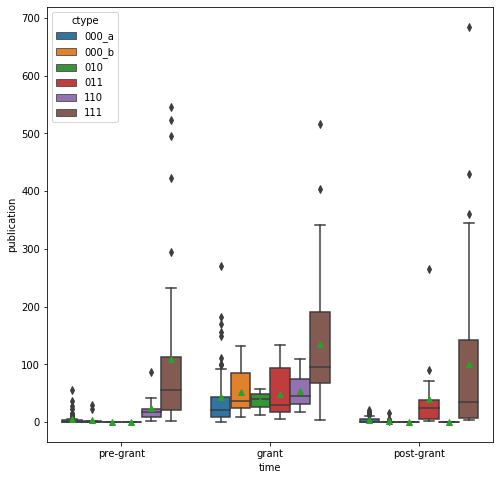

In [54]:
x = ["pre-grant", "grant", "post-grant"]
ctype = ['000_a', '000_b', '010', '011', '110', '111']
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "period": [dict_periods[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

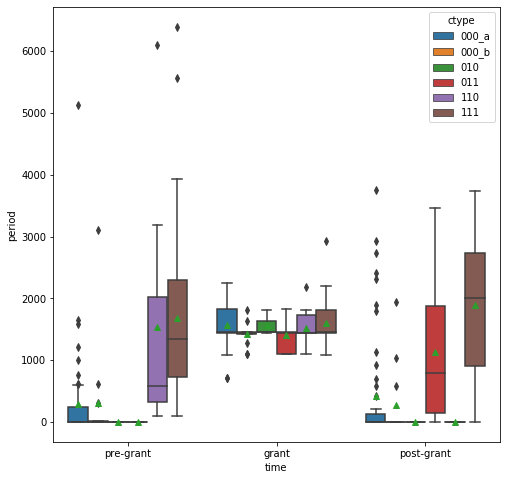

In [55]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


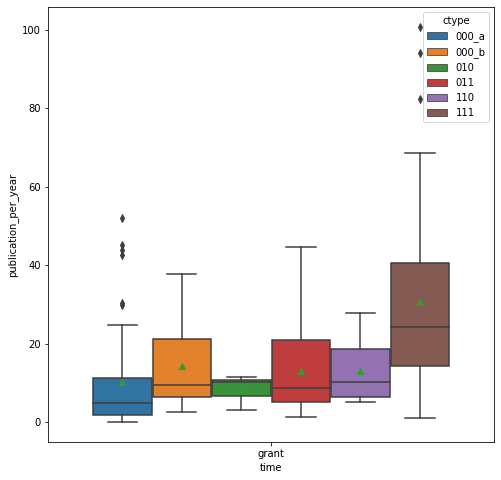

In [56]:
temp_data = box_plot_data[box_plot_data.time=="grant"]
temp_data["publication_per_year"] = temp_data["publication"]/temp_data["period"]*365
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication_per_year", hue="ctype", data=temp_data, showmeans=True, hue_order=ctype)


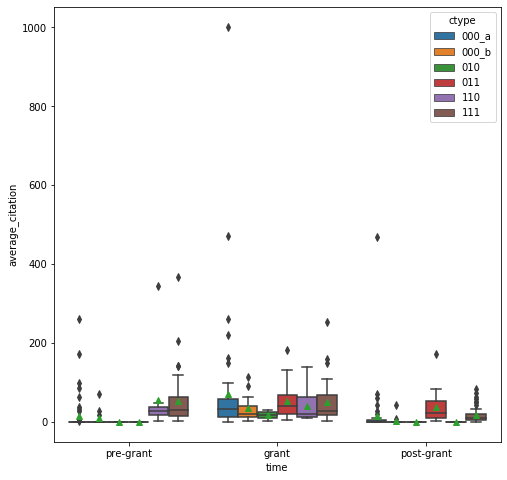

In [57]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

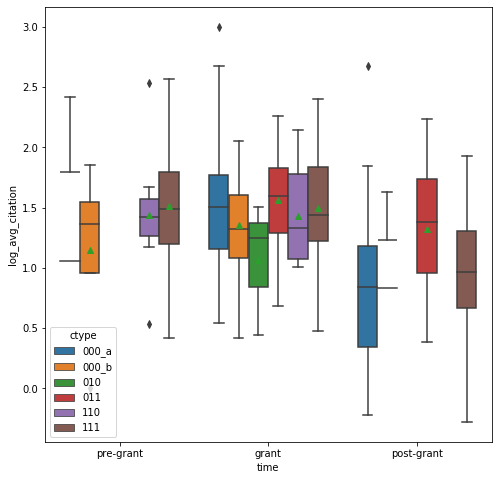

In [58]:
np.seterr(divide = 'ignore') 
box_plot_data["log_avg_citation"] = np.log10(box_plot_data["citation"]/box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_avg_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

In [59]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


Counter({1: 1258, 2: 457, 3: 174, 5: 93, 4: 83, 6: 15, 7: 4, 8: 2, 0: 2})


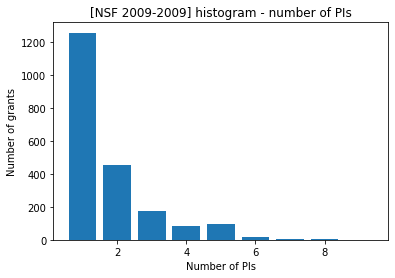

In [60]:
histogram_num_pis(data, years, div_type.keys())

In [61]:
grant_list = [k for k, d in data.items() if d["org"] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [62]:
no_publications = []
collab_type = {}
dict_publications = {}
dict_citations = {}
dict_periods = {}
convert_t = lambda t: datetime.strptime(t, "%Y-%m-%dT%X")

for grant_id in grant_list:
    _,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    if len(G_all.edges) == 0:
        no_publications.append(grant_id)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    acting_authors = []
    G = G_all.subgraph(pis)
    if len(G.edges) == 0:
        collab_type[grant_id] = "000"
        
    publications = {"pre-grant":0, "grant":0, "post-grant":0}
    citations = {"pre-grant":0, "grant":0, "post-grant":0}
    dates = [convert_t(data["date"]) for _,_,data in G_all.edges.data()]
    periods = {"pre-grant":max(0, (ts-min(dates)).days), "grant":(te-ts).days, "post-grant":max(0, (max(dates)-te).days)}
    for idx, nxtype in enumerate(["pre-grant", "grant", "post-grant"]):
        for u,v,data in G_all.edges.data():
            acting_authors.extend([u, v])
            if nxtype == "pre-grant":
                publications[nxtype] += 1 if convert_t(data["date"]) < ts else 0
                citations[nxtype] += data["citation"] if convert_t(data["date"]) < ts else 0
            if nxtype == "grant":
                publications[nxtype] += 1 if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
                citations[nxtype] += data["citation"] if ts <= convert_t(data["date"]) and convert_t(data["date"]) <= te else 0
            if nxtype == "post-grant":
                publications[nxtype] += 1 if te < convert_t(data["date"]) else 0
                citations[nxtype] += data["citation"] if te < convert_t(data["date"]) else 0
    dict_publications[grant_id] = publications
    dict_citations[grant_id] = citations
    dict_periods[grant_id] = periods
    
    if grant_id in collab_type and collab_type[grant_id] == "000":
#         print(grant_id, set(acting_authors).intersection(set(pis)))
        acting_pis = len(set(acting_authors).intersection(set(pis)))
        if acting_pis == 1: collab_type[grant_id] = "000_a"
        if acting_pis == 2: collab_type[grant_id] = "000_b"
        if acting_pis == 0: collab_type[grant_id] = "000_c"    
    else:
        collab_type[grant_id] = "{}{}{}".format(1 if publications["pre-grant"] > 0 else 0, 1 if publications["grant"] > 0 else 0, 1 if publications["post-grant"] > 0 else 0)
#     print(grant_id, collab_type[grant_id], publications.values(), periods.values(), citations.values())
    

In [63]:
Counter(collab_type.values())

Counter({'000_a': 105,
         '011': 34,
         '110': 26,
         '111': 110,
         '010': 10,
         '000_b': 40,
         '000_c': 10,
         '100': 1})

In [64]:
print("total {} grant with 2PIs - no publication: {}".format(len(grant_list), len(no_publications)))

total 457 grant with 2PIs - no publication: 121


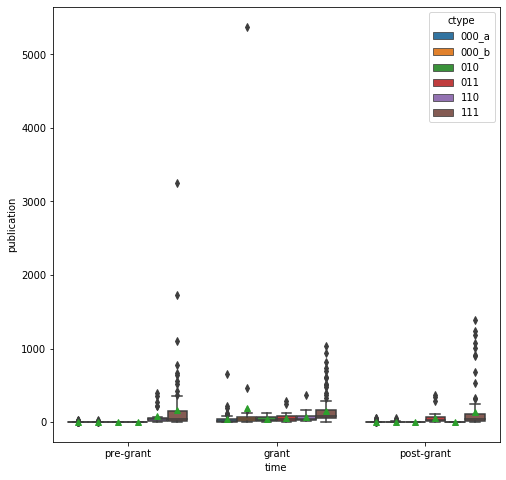

In [65]:
x = ["pre-grant", "grant", "post-grant"]
ctype = ['000_a', '000_b', '010', '011', '110', '111']
box_plot_data = pd.DataFrame({
    "time": [time for time in x for k, v in collab_type.items() if v in ctype],
    "period": [dict_periods[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "publication": [dict_publications[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "citation": [dict_citations[k][time] for time in x for k, v in collab_type.items() if v in ctype],
    "ctype": [v for time in x for k, v in collab_type.items() if v in ctype]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-pa

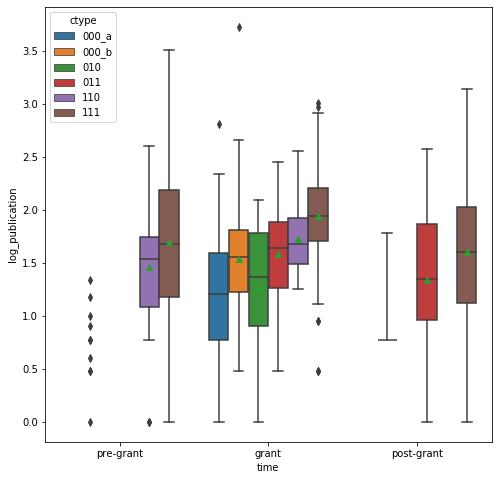

In [66]:
np.seterr(divide = 'ignore') 
box_plot_data["log_publication"] = np.log10(box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_publication", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

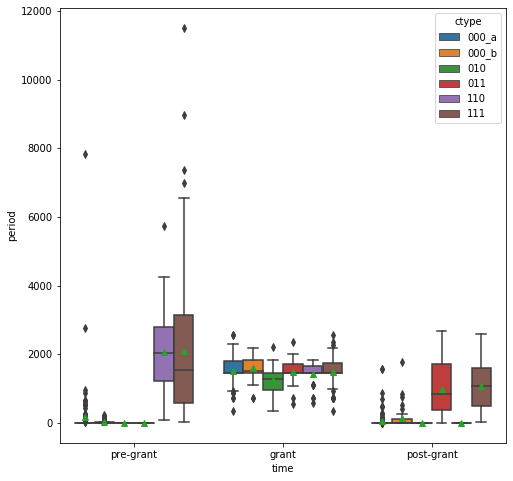

In [67]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="period", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/minjeongshin/miniconda2/envs/mm/lib/python3.7/site-pa

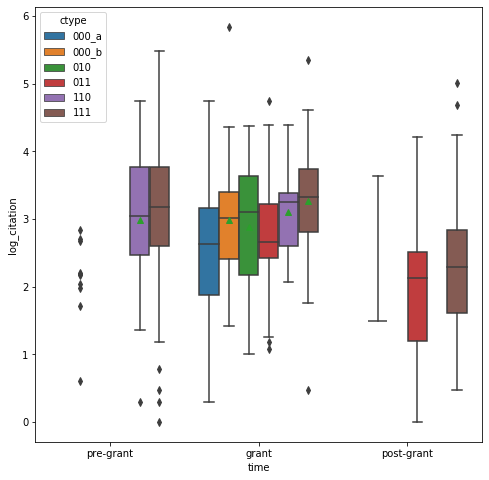

In [73]:
box_plot_data["log_citation"] = np.log10(box_plot_data["citation"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

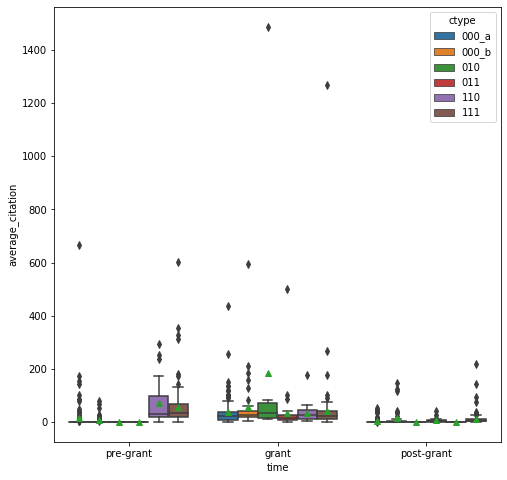

In [70]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="average_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)

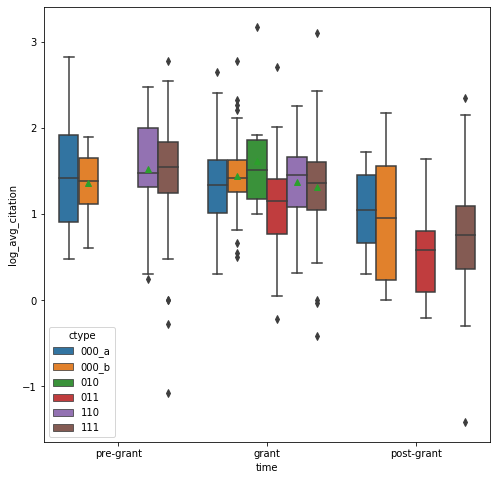

In [71]:
np.seterr(divide = 'ignore') 
box_plot_data["log_avg_citation"] = np.log10(box_plot_data["citation"]/box_plot_data["publication"])
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="time", y="log_avg_citation", hue="ctype", data=box_plot_data, showmeans=True, hue_order=ctype)